# Imports & Load Data

In [83]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import zero_one_loss

# Prepare Dataset

In [84]:
import gzip, pickle
with gzip.open("mnist_2_vs_9.gz") as f:
    data = pickle.load(f, encoding="bytes")
    Xtrain, Ytrain, Xtest, Ytest, Xdev, Ydev = \
        data[b"Xtrain"], data[b"Ytrain"], data[b"Xtest"], \
        data[b"Ytest"], data[b"Xdev"], data[b"Ydev"]

# Preparing Training Dataset
Xtrain = torch.tensor(Xtrain)
Ytrain = torch.tensor(Ytrain)
train = torch.utils.data.TensorDataset(Xtrain, Ytrain)
train_loader = DataLoader(train, batch_size = 64, shuffle = False)

# Preparing Validation Dataset
Xdev = torch.tensor(Xdev)
Ydev = torch.tensor(Ydev)
dev = torch.utils.data.TensorDataset(Xdev, Ydev)
dev_loader = DataLoader(dev, batch_size = 64, shuffle = False)

# Preparing Test Dataset
Xtest = torch.tensor(Xtest)
Ytest = torch.tensor(Ytest)
test = torch.utils.data.TensorDataset(Xtest, Ytest)
test_loader = DataLoader(test, batch_size=64 ,shuffle = False)


# train_loader is like a dictionary like this:
# [ 
#   [batch 1 : [features, labels] ] 
#   [batch 2 : [features, labels] ] 
#   [etc.,                        ] ]

# Define Network

In [85]:
#Define Class Network for ANN
class Network(nn.Module):
	
	def __init__(self):
		super(Network, self).__init__()
		self.fc1 = nn.Linear(784, 100)
		self.fc2 = nn.Linear(100, 2)
		self.drop = nn.Dropout(p=0.5) #probability that a neuron will be zeroed

	def forward(self, x):
		x = self.fc1(x)
		x = self.drop(x)
		x = torch.sigmoid(x)
		x = self.fc2(x)
		return x

# Initialize Network Object
model = Network()

# Loss Object
error = nn.CrossEntropyLoss()

learning_rate = 0.002
epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the Network

In [88]:
training_loss = []
validation_loss = []
validation_accuracy = []
zero_one_error = {
    'train' : [],
    'val' : []
}
iterations = []
count=0

for epoch in range(epochs):

    # Training will run for epoch = 100 cycles.
    # Each cycle consists of all batches in the training set.
    # For each batch, we perform forward and back propagation to compute loss and update parameters.
    
    for i, (features, labels) in enumerate(train_loader):
    
        '''     i                         -> Batch number
                features                  -> Training features
                labels                    -> Training labels.
                train_loader              -> Tensor dataset with all batches.
                epochs                    -> 100
                batch_size                -> 64
                number of batches         -> 155
                Total training examples   -> 9956
                Model                     -> ANN with 1 hidden layer(s).
                Activation                -> Sigmoid.
                LOSS                      -> Cross Entropy Loss Function.
                Learning_rate             -> 0.001                          '''
        
        # clear gradients
        optimizer.zero_grad()
    
        # forward pass
        predicted = model(features)
    
        # calculate loss
        loss = error(predicted, labels)
    
        # backward pass
        loss.backward()
    
        # update parameters
        optimizer.step()
        
        count += 1
    
        # for every 30 batches the model sees, predict validation set to test the network & choose optimal hyperparameters.
        if count % 30 == 0:
        
            correct = 0
            total = 0
        
            for val_features, val_labels in dev_loader:
            
                # Forward propagation
                outputs = model(val_features)
                
                # calculate loss for validation set
                val_loss = error(outputs, val_labels)
                
                # Get predictions from the maximum value.
                val_pred = torch.max(outputs.data, 1)[1]
                
                ''' * outputs.data will have the values(weights[0] & labels[1]) of neurons in the output layer. 
                        i.e., the predictions for each neuron.
                    * torch.max() returns the maximum value(i.e., the max. probability) of a neuron.
                    * torch.max(x, 1) returns the maximum value accross all features(or neurons) in a training example 
                        as the prediction class for that record.
                    * example here the output layer consists of 2 neurons, 
                    * so for an example, it'll generate the max value of those 2 as the predicted class and weights. '''
                
                # Total number of labels
                total += len(val_labels) # adding len(labels) from each batch

                # Total correct predictions
                correct += (val_pred == val_labels).sum()
            
            accuracy = 100 * correct / float(total)
        
            training_loss.append(loss.data)
            validation_loss.append(val_loss.data)
            validation_accuracy.append(accuracy)
            iterations.append(count)
        
    # for every 10 epoch cycles, Print Training Loss & Accuracy of validation set.
    if epoch % 10 == 0:
        # Print Loss
        print('epoch: {}  Loss: {}  Accuracy: {} %'.format(epoch, loss.data, accuracy))


epoch: 0  Loss: 0.6707589626312256  Accuracy: 72.21937561035156 %


KeyboardInterrupt: 

# Plots

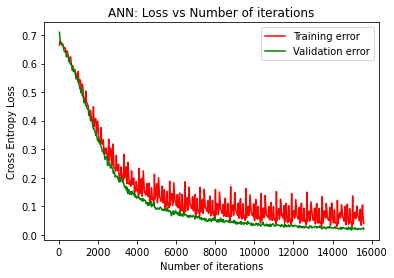

'\n# visualization accuracy \nplt.plot(iterations,training_loss, color = "red", label = "Training error")\nplt.plot(iterations,validation_loss, color = "green", label = "Validation error")\nplt.legend()\nplt.xlabel("Number of iterations")\nplt.ylabel("Accuracy")\nplt.title("ANN: Accuracy vs Number of iterations")\nplt.show()'

In [80]:
# visualization loss 
plt.plot(iterations,training_loss, color = "red", label = "Training error")
plt.plot(iterations,validation_loss, color = "green", label = "Validation error")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Cross Entropy Loss")
plt.title("ANN: Loss vs Number of iterations")
plt.show()

'''
# visualization accuracy 
plt.plot(iterations,training_loss, color = "red", label = "Training error")
plt.plot(iterations,validation_loss, color = "green", label = "Validation error")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iterations")
plt.show()'''


# Predict Test Data

In [81]:
# Predicting Test Data
tot = crt = acc = 0
for features, labels in test_loader:
    output = model(features)
    predicted = torch.max(output.data, 1)[1]
    tot += len(labels)     
    crt += (predicted == labels).sum()

acc = 100 * crt / float(tot)
print("Test Accuracy: {} %".format(acc))

Test Accuracy: 98.04017639160156 %
